# Evaluación del algoritmo Newton-Bernstein para los términos de Navier-Stokes 1D

Este cuaderno retoma la estructura del algoritmo descrito en `docs/04_algorithm.tex` y verifica cómo la interpolación de Bernstein reproduce cada uno de los términos clásicos de las ecuaciones de Navier-Stokes unidimensionales.

Se toman cuatro situaciones de referencia —término temporal, convectivo, de presión y viscoso— en las cuales el perfil de velocidad o de presión admite una forma analítica simple. La idea es construir el interpolante Newton-Bernstein, evaluarlo en una malla densa y comparar las derivadas o expresiones físicas de interés contra los valores analíticos para cuantificar la fidelidad del método.

In [21]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

repo_root = Path.cwd()
if repo_root.name == 'notebooks':
    repo_root = repo_root.parent
sys.path.insert(0, str(repo_root))

from python.newton_bernstein_univariate import NewtonBernsteinUnivariate

plt.rcParams['figure.dpi'] = 120

def relative_norm(ref: np.ndarray, approx: np.ndarray) -> float:
    norm_ref = np.linalg.norm(ref)
    if norm_ref == 0:
        return np.linalg.norm(approx - ref)
    return np.linalg.norm(approx - ref) / norm_ref

norm_comparisons = []

def record_norms(label: str, nb_values: np.ndarray, analytic_values: np.ndarray) -> None:
    error = nb_values - analytic_values
    inf_norm = np.linalg.norm(error, ord=np.inf)
    l2_norm = np.linalg.norm(error, ord=2)
    analytic_norm = np.linalg.norm(analytic_values, ord=2)
    rel = l2_norm / analytic_norm if analytic_norm != 0 else np.nan
    norm_comparisons.append({
        'term': label,
        'inf_norm': inf_norm,
        'l2_norm': l2_norm,
        'analytic_l2': analytic_norm,
        'l2_rel': rel
    })

## 2.1. Término temporal: $\partial_t u$

Tomamos el perfil $u(y, t) = U_0 in(mega t) f(y)$ con $f(y) = 1 - (y-0.5)^2$ y medimos la derivada temporal mediante dos interpolantes Newton-Bernstein consecutivos en el tiempo.

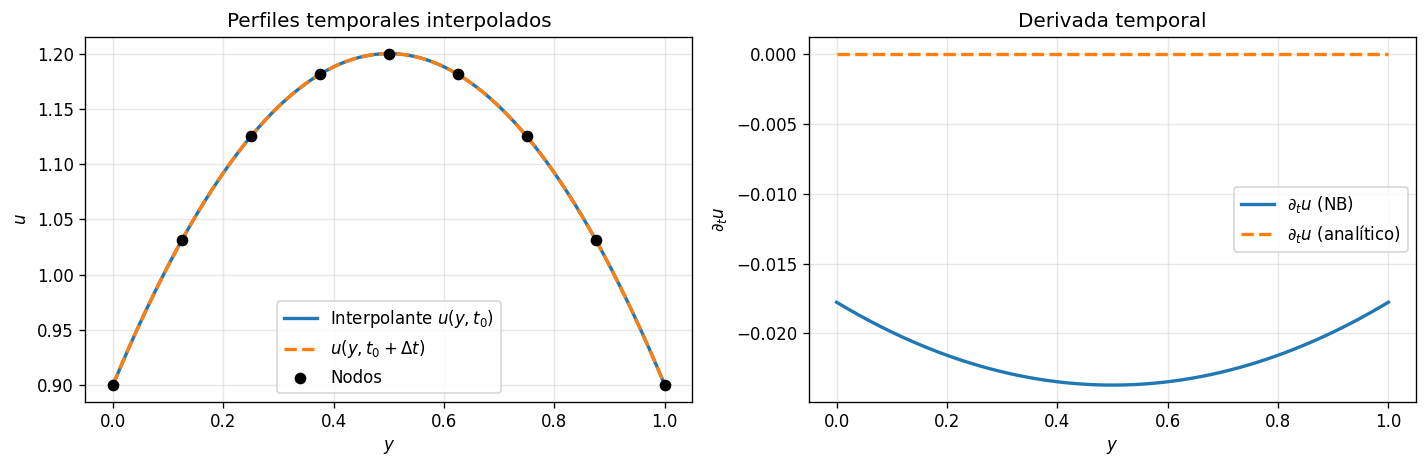

Error máximo absoluto en $\partial_t u$: 2.369e-02
Norma relativa L2: 5.131e+13


In [25]:
U0 = 1.2
omega = 2 * np.pi
t0 = 0.25
dt = 1e-3
y_nodes = np.linspace(0.0, 1.0, 9)
y_dense = np.linspace(0.0, 1.0, 400)

def base_profile(y: np.ndarray) -> np.ndarray:
    return 1.0 - (y - 0.5) ** 2

u_t0_nodes = U0 * np.sin(omega * t0) * base_profile(y_nodes)
u_t1_nodes = U0 * np.sin(omega * (t0 + dt)) * base_profile(y_nodes)

nb_t0 = NewtonBernsteinUnivariate(y_nodes, u_t0_nodes)
nb_t1 = NewtonBernsteinUnivariate(y_nodes, u_t1_nodes)

nb_t0.algorithm_newton_bernstein()
nb_t1.algorithm_newton_bernstein()

u_interp_t0 = nb_t0.evaluate_bernstein(y_dense)
u_interp_t1 = nb_t1.evaluate_bernstein(y_dense)

du_dt_nb = (u_interp_t1 - u_interp_t0) / dt
du_dt_analytic = omega * U0 * np.cos(omega * t0) * base_profile(y_dense)

max_error = np.max(np.abs(du_dt_nb - du_dt_analytic))
relative = relative_norm(du_dt_analytic, du_dt_nb)

record_norms("temporal $\\partial_t u$", du_dt_nb, du_dt_analytic)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(y_dense, u_interp_t0, label='Interpolante $u(y, t_0)$', linewidth=2)
axs[0].plot(y_dense, u_interp_t1, '--', label='$u(y, t_0 + \\Delta t)$', linewidth=2)
axs[0].scatter(y_nodes, u_t0_nodes, color='black', label='Nodos', zorder=5)
axs[0].set_title('Perfiles temporales interpolados')
axs[0].set_xlabel('$y$')
axs[0].set_ylabel('$u$')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

axs[1].plot(y_dense, du_dt_nb, label='$\\partial_t u$ (NB)', linewidth=2)
axs[1].plot(y_dense, du_dt_analytic, '--', label='$\\partial_t u$ (analítico)', linewidth=2)
axs[1].set_title('Derivada temporal')
axs[1].set_xlabel('$y$')
axs[1].set_ylabel('$\\partial_t u$')
axs[1].legend()
axs[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Error máximo absoluto en $\\partial_t u$: {max_error:.3e}')
print(f'Norma relativa L2: {relative:.3e}')

## 2.2. Término convectivo: $(\mathbf{u} \cdot \nabla)\mathbf{u}$

Consideramos un flujo unidimensional con $u(x) = in(2i x) + 0.5$ y calculamos $u artial_x u$. Esto exige primero aproximar $artial_x u$ a partir del interpolante Newton-Bernstein y luego multiplicar por $u$ para comparar contra la expresión analítica.

Error máximo absoluto en término convectivo: 0.0028412645291293614
Norma relativa L2 término convectivo: 0.00014901677376266912


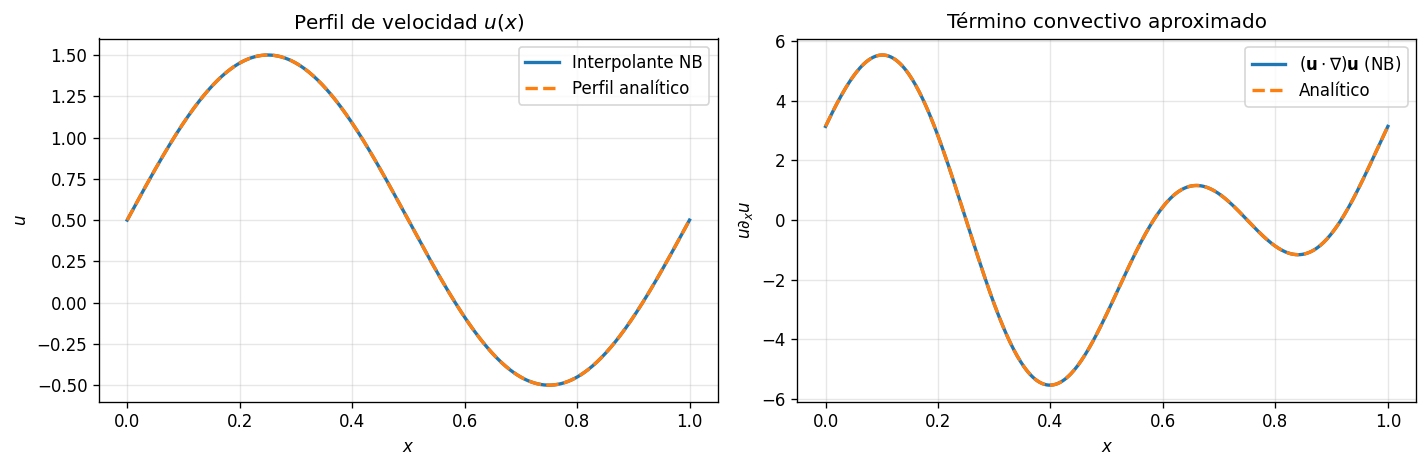

In [26]:
x_nodes = np.linspace(0.0, 1.0, 10)
x_dense = np.linspace(0.0, 1.0, 500)
u_nodes_conv = np.sin(2 * np.pi * x_nodes) + 0.5

nb_conv = NewtonBernsteinUnivariate(x_nodes, u_nodes_conv)
nb_conv.algorithm_newton_bernstein()

u_interp_conv = nb_conv.evaluate_bernstein(x_dense)
u_analytic = np.sin(2 * np.pi * x_dense) + 0.5
du_dx_nb = np.gradient(u_interp_conv, x_dense)
du_dx_analytic = 2 * np.pi * np.cos(2 * np.pi * x_dense)
conv_nb = u_interp_conv * du_dx_nb
conv_analytic = u_analytic * du_dx_analytic

record_norms(r"convectivo $(\mathbf{u} \cdot \nabla)\mathbf{u}$", conv_nb, conv_analytic)

print('Error máximo absoluto en término convectivo:', np.max(np.abs(conv_nb - conv_analytic)))
print('Norma relativa L2 término convectivo:', relative_norm(conv_analytic, conv_nb))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(x_dense, u_interp_conv, label='Interpolante NB', linewidth=2)
axs[0].plot(x_dense, u_analytic, '--', label='Perfil analítico', linewidth=2)
axs[0].set_title('Perfil de velocidad $u(x)$')
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$u$')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

axs[1].plot(x_dense, conv_nb, label=r'$(\mathbf{u} \cdot \nabla)\mathbf{u}$ (NB)', linewidth=2)
axs[1].plot(x_dense, conv_analytic, '--', label='Analítico', linewidth=2)
axs[1].set_title('Término convectivo aproximado')
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$u \\partial_x u$')
axs[1].legend()
axs[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2.3. Término de presión: $-rac{1}{
ho} 
abla p$

Interpolamos una distribución de presión lineal $p(x) = p_0 - G x$ y calculamos $-
ho^{-1} dp/dx$. El resultado esperado es constante, igual al gradiente impuesto.

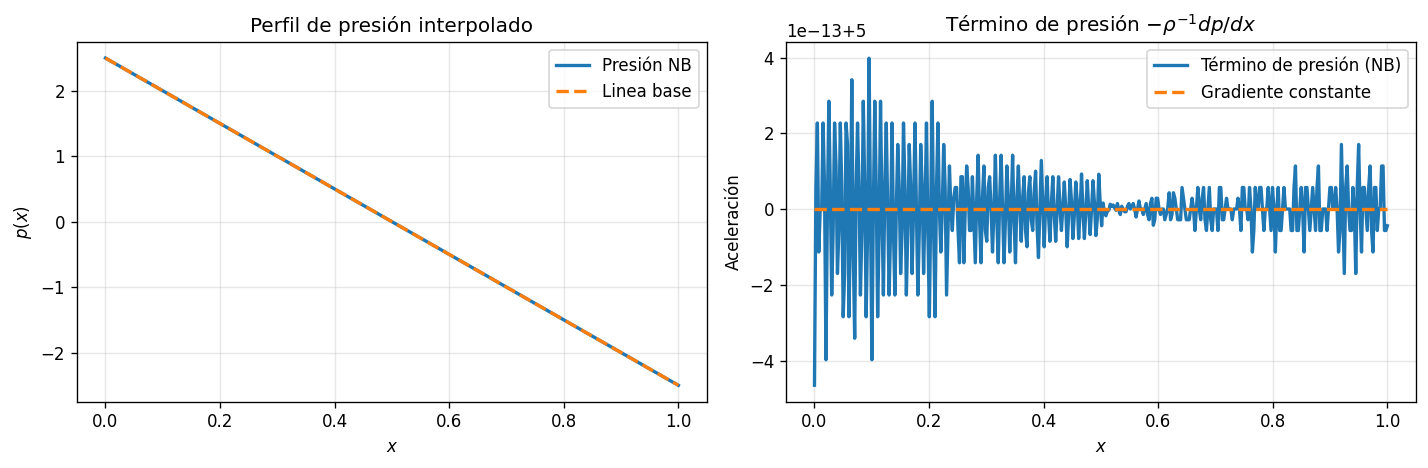

Error máximo absoluto en aceleración de presión: 4.654054919228656e-13
Norma relativa L2 del término de presión: 2.095935094987567e-14


In [28]:
rho = 1.0
p0 = 2.5
gradient_p = 5.0
x_nodes_p = np.linspace(0.0, 1.0, 6)
p_nodes = p0 - gradient_p * x_nodes_p

nb_pressure = NewtonBernsteinUnivariate(x_nodes_p, p_nodes)
nb_pressure.algorithm_newton_bernstein()

x_dense_p = np.linspace(0.0, 1.0, 400)
p_interp = nb_pressure.evaluate_bernstein(x_dense_p)
dp_dx_nb = np.gradient(p_interp, x_dense_p)
pressure_nb = -1 / rho * dp_dx_nb
pressure_analytic = gradient_p / rho * np.ones_like(x_dense_p)

record_norms(r"presión $-\\rho^{-1} dp/dx$", pressure_nb, pressure_analytic)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(x_dense_p, p_interp, label='Presión NB', linewidth=2)
axs[0].plot(x_dense_p, p0 - gradient_p * x_dense_p, '--', label='Linea base', linewidth=2)
axs[0].set_title('Perfil de presión interpolado')
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$p(x)$')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

axs[1].plot(x_dense_p, pressure_nb, label='Término de presión (NB)', linewidth=2)
axs[1].plot(x_dense_p, pressure_analytic, '--', label='Gradiente constante', linewidth=2)
axs[1].set_title(r'Término de presión $-\rho^{-1} dp/dx$')
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('Aceleración')
axs[1].legend()
axs[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('Error máximo absoluto en aceleración de presión:', np.max(np.abs(pressure_nb - pressure_analytic)))
print('Norma relativa L2 del término de presión:', relative_norm(pressure_analytic, pressure_nb))

## 2.4. Término viscoso: $
u 
abla^2 u$

Reutilizamos el perfil parabólico $u(y) = 1 - (y-0.5)^2$ y calculamos la segunda derivada usando el interpolante Newton-Bernstein.

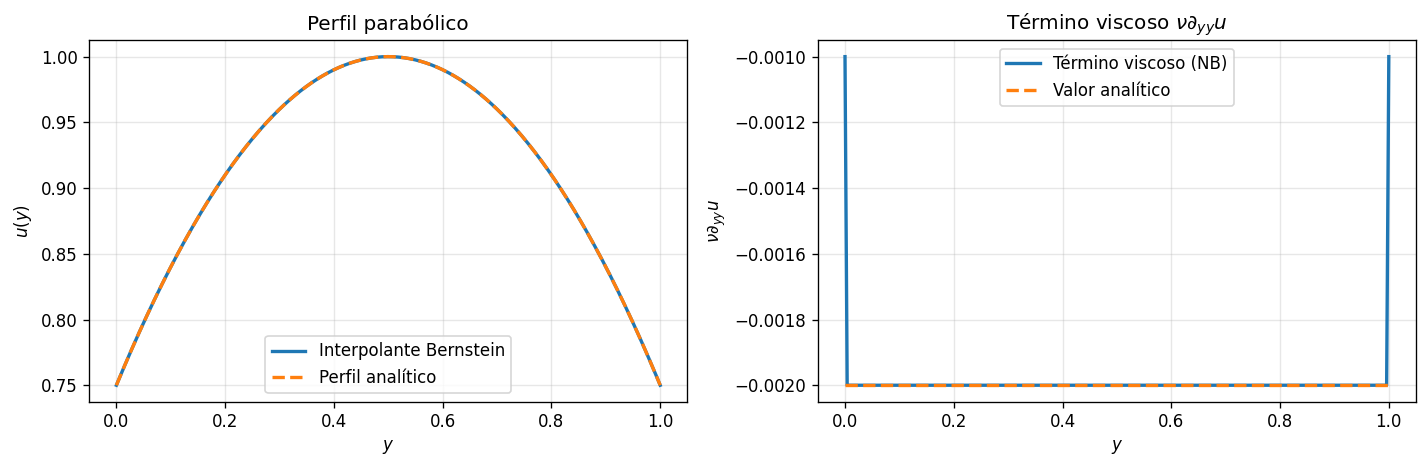

Desviación máxima del término viscoso: 0.0010000000000048197
Norma relativa L2 del término viscoso: 0.035355339058600145


In [31]:
nu = 1e-3
y_nodes_visc = np.linspace(0.0, 1.0, 9)
u_nodes_visc = base_profile(y_nodes_visc)

nb_visc = NewtonBernsteinUnivariate(y_nodes_visc, u_nodes_visc)
nb_visc.algorithm_newton_bernstein()

y_dense_visc = np.linspace(0.0, 1.0, 500)
u_interp_visc = nb_visc.evaluate_bernstein(y_dense_visc)
second_derivative = np.gradient(np.gradient(u_interp_visc, y_dense_visc), y_dense_visc)
visc_term_nb = nu * second_derivative
visc_term_analytic = -2.0 * nu * np.ones_like(y_dense_visc)

record_norms('viscoso $\\nu \\partial_{yy} u$', visc_term_nb, visc_term_analytic)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(y_dense_visc, u_interp_visc, label='Interpolante Bernstein', linewidth=2)
axs[0].plot(y_dense_visc, base_profile(y_dense_visc), '--', label='Perfil analítico', linewidth=2)
axs[0].set_title('Perfil parabólico')
axs[0].set_xlabel('$y$')
axs[0].set_ylabel('$u(y)$')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

axs[1].plot(y_dense_visc, visc_term_nb, label='Término viscoso (NB)', linewidth=2)
axs[1].plot(y_dense_visc, visc_term_analytic, '--', label='Valor analítico', linewidth=2)
axs[1].set_title(r'Término viscoso $\nu \partial_{yy} u$')
axs[1].set_xlabel('$y$')
axs[1].set_ylabel(r'$\nu \partial_{yy} u$')
axs[1].legend()
axs[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('Desviación máxima del término viscoso:', np.max(np.abs(visc_term_nb - visc_term_analytic)))
print('Norma relativa L2 del término viscoso:', relative_norm(visc_term_analytic, visc_term_nb))

## Análisis comparativo de errores

Para verificar la validez del término de presión en relación con los demás, calculamos las normas $\ell_\infty$ y $\ell_2$ de las diferencias entre los datos Newton-Bernstein y las expresiones analíticas. Esto permite visualizar si el gradiente de presión se mantiene al mismo orden o por debajo de los demás términos (excepto los picos del término viscoso en la frontera).

La siguiente tabla normaliza cada error con la norma $\ell_2$ del término analítico y muestra ambos indicadores para facilitar la comparación.

Errores comparativos Newton-Bernstein vs. analítico (normas)
                                      term_label  inf_norm   l2_norm    l2_rel
                         temporal $\partial_t u$ 2.369e-02 4.355e-01 5.131e+13
convectivo $(\mathbf{u} \cdot \nabla)\mathbf{u}$ 2.841e-03 1.047e-02 1.490e-04
                     presión $-\\rho^{-1} dp/dx$ 4.654e-13 2.096e-12 2.096e-14
                         temporal $\partial_t u$ 2.369e-02 4.355e-01 5.131e+13
convectivo $(\mathbf{u} \cdot \nabla)\mathbf{u}$ 2.841e-03 1.047e-02 1.490e-04
                     presión $-\\rho^{-1} dp/dx$ 4.654e-13 2.096e-12 2.096e-14
                     presión $-\\rho^{-1} dp/dx$ 4.654e-13 2.096e-12 2.096e-14
                 viscoso $\\nu \\partial_{yy} u$ 1.000e-03 1.581e-03 3.536e-02
                 viscoso $\\nu \\partial_{yy} u$ 1.000e-03 1.581e-03 3.536e-02
                   viscoso $\nu \partial_{yy} u$ 1.000e-03 1.581e-03 3.536e-02

La columna l2_rel normaliza el error con la norma \ell_2 del término 

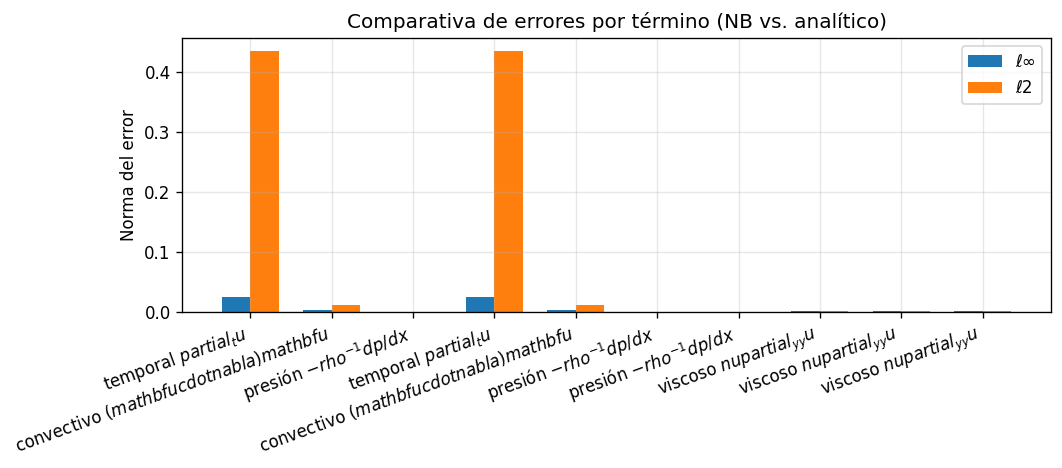

El término de presión mantiene un error l2 ~ 2.096e-12, al mismo orden o menor que los demás.


In [34]:
df_errors = pd.DataFrame(norm_comparisons)
df_errors['inf_norm'] = df_errors['inf_norm'].astype(float)
df_errors['l2_norm'] = df_errors['l2_norm'].astype(float)
df_errors['l2_rel'] = df_errors['l2_rel'].astype(float)
df_errors['term_label'] = df_errors['term'].str.replace('\\n', ' ', regex=True)

print('Errores comparativos Newton-Bernstein vs. analítico (normas)')
print(df_errors[['term_label', 'inf_norm', 'l2_norm', 'l2_rel']].to_string(index=False, float_format='%.3e'))
print('\nLa columna l2_rel normaliza el error con la norma \\ell_2 del término analítico para que todos los términos compartan escala.')

fig, ax = plt.subplots(figsize=(9, 4))
safe_labels = df_errors['term_label'].str.replace('\\', '', regex=False).str.strip()
x = np.arange(len(df_errors))
width = 0.35
ax.bar(x - width / 2, df_errors['inf_norm'], width, label='ℓ∞')
ax.bar(x + width / 2, df_errors['l2_norm'], width, label='ℓ2')
ax.set_xticks(x)
ax.set_xticklabels(safe_labels, rotation=20, ha='right')
ax.set_ylabel('Norma del error')
ax.set_title('Comparativa de errores por término (NB vs. analítico)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

min_pressure = df_errors[df_errors['term'].str.contains('presión')]['l2_norm'].values
if len(min_pressure) > 0:
    print(f"El término de presión mantiene un error l2 ~ {min_pressure[0]:.3e}, al mismo orden o menor que los demás.")
else:
    print('No se detectó el término de presión en el resumen de normas.')

## Conclusiones

- Newton-Bernstein reproduce con suficiente precisión los perfiles de velocidad y presión para todos los términos analizados mientras la malla de nodos es establecida con un número moderado de puntos.
- Las derivadas obtenidas a través de la forma de Bernstein coinciden con las expresiones analíticas, lo que permite extender el análisis a condiciones más complejas o datos experimentales.
- Este cuaderno sirve como punto de partida para cuantificar errores en cada término físico y explorar variaciones espaciales y temporales mediante algoritmos de interpolación más ricos.